**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/trend).**

---



# Introduction #

Run this cell to set everything up!

In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path().resolve().parent / "src"))

from utils import (
    create_multistep_example,
    load_multistep_data,
    make_lags,
    make_leads,
    make_multistep_target,
    plot_multistep,
    plot_lags,
    seasonal_plot,# annotations: https://stackoverflow.com/a/49238256/5769929
    plot_periodogram,
)

from plotting import plot_params

In [2]:
# Setup notebook
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/store-sales-time-series-forecasting')

retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

-------------------------------------------------------------------------------

# 1) Determine trend with a moving average plot

The *US Retail Sales* dataset contains monthly sales data for a number of retail industries in the United States. Run the next cell to see a plot of the *Food and Beverage* series.

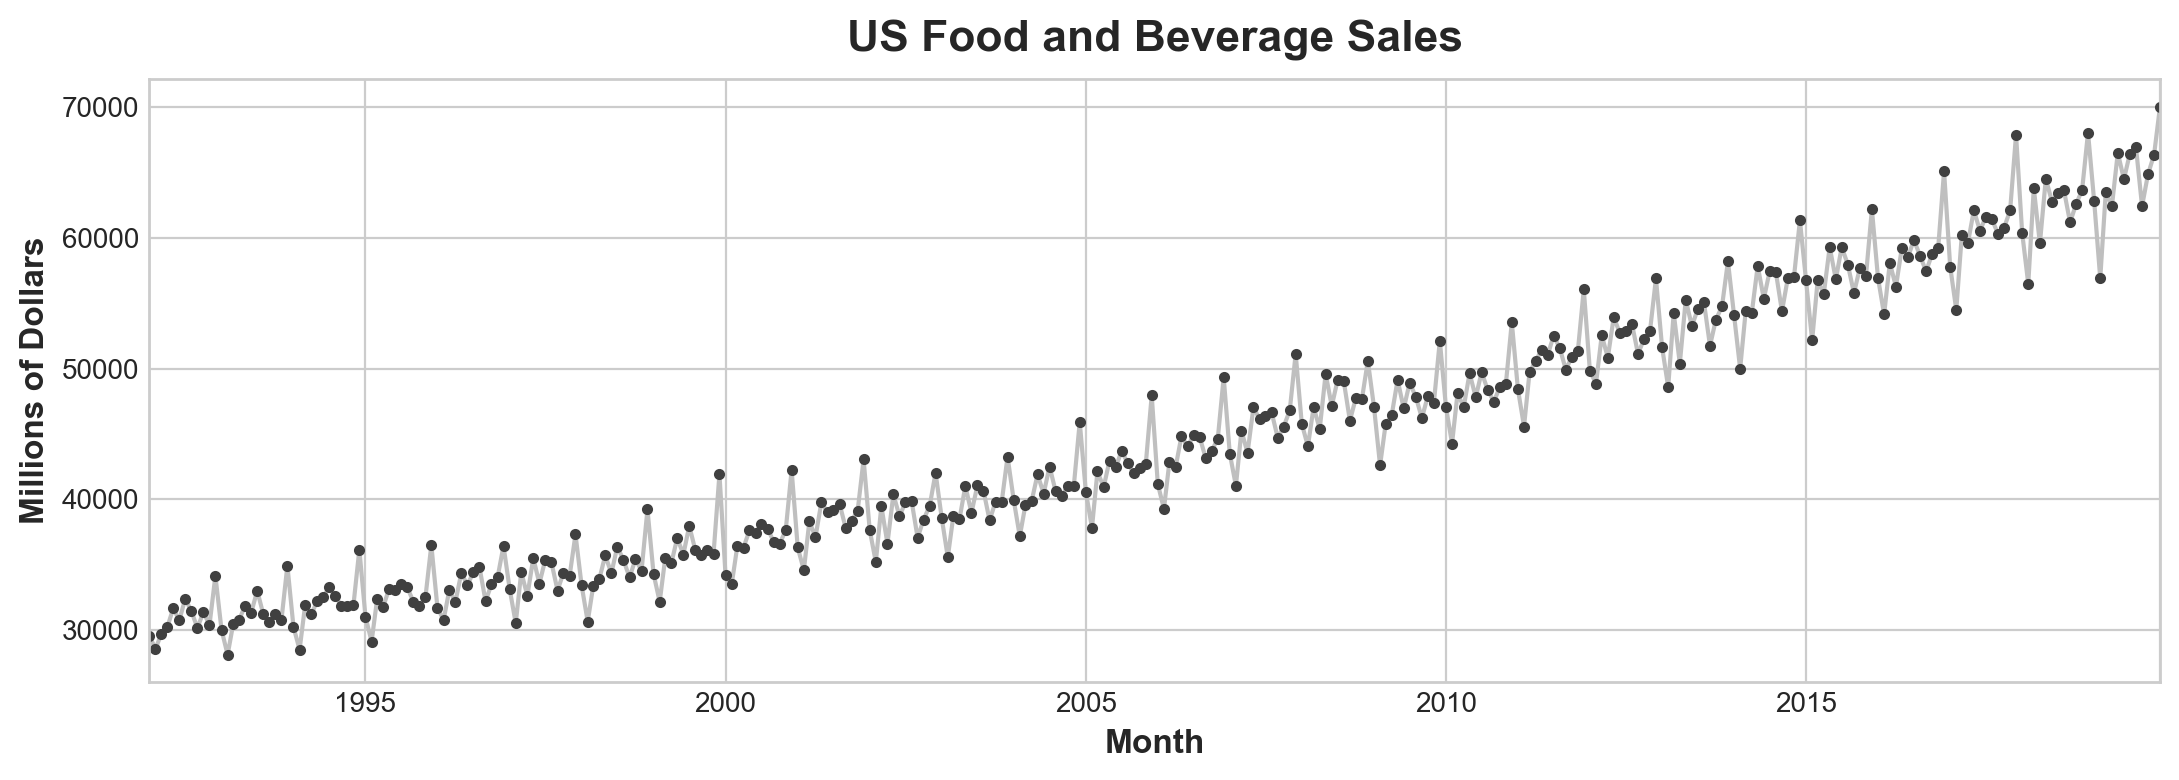

In [3]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

In [4]:
food_sales.head()

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
Freq: D, Name: FoodAndBeverage, dtype: int64

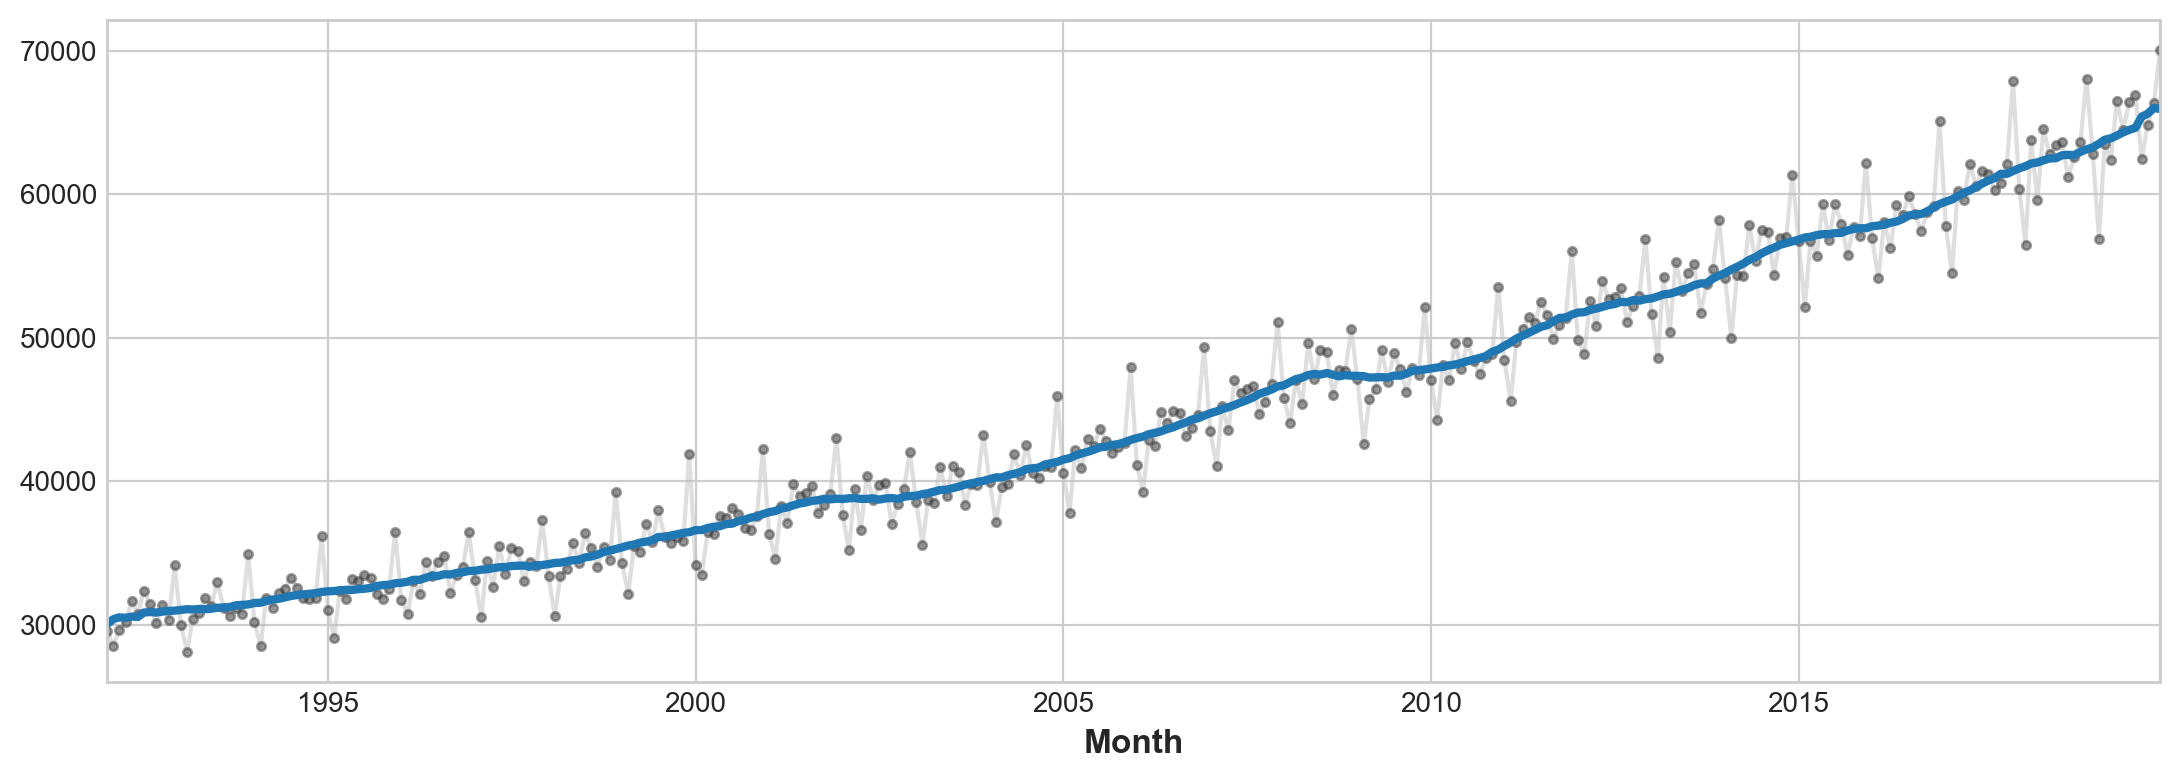

In [5]:
# YOUR CODE HERE: Add methods to `food_sales` to compute a moving
# average with appropriate parameters for trend estimation.
trend = food_sales.rolling(
    window = 12,
    center = True,
    min_periods = 6
).mean()

# Check your answer
#q_1.check()

# Make a plot
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

Now make a moving average plot to estimate the trend for this series.

In [6]:
# Uncomment to get a hint or solution
#q_1.hint()
#q_1.solution()

-------------------------------------------------------------------------------

# 2) Identify trend

What order polynomial trend might be appropriate for the *Food and Beverage Sales* series? Can you think of a non-polynomial curve that might work even better?

Once you've thought about it, run this cell for some discussion.

In [7]:
# View the solution (Run this cell to receive credit!)
#q_2.check()

-------------------------------------------------------------------------------

We'll continue using the time series of average sales in this lesson. Run this cell to see a moving average plot of `average_sales` estimating the trend.

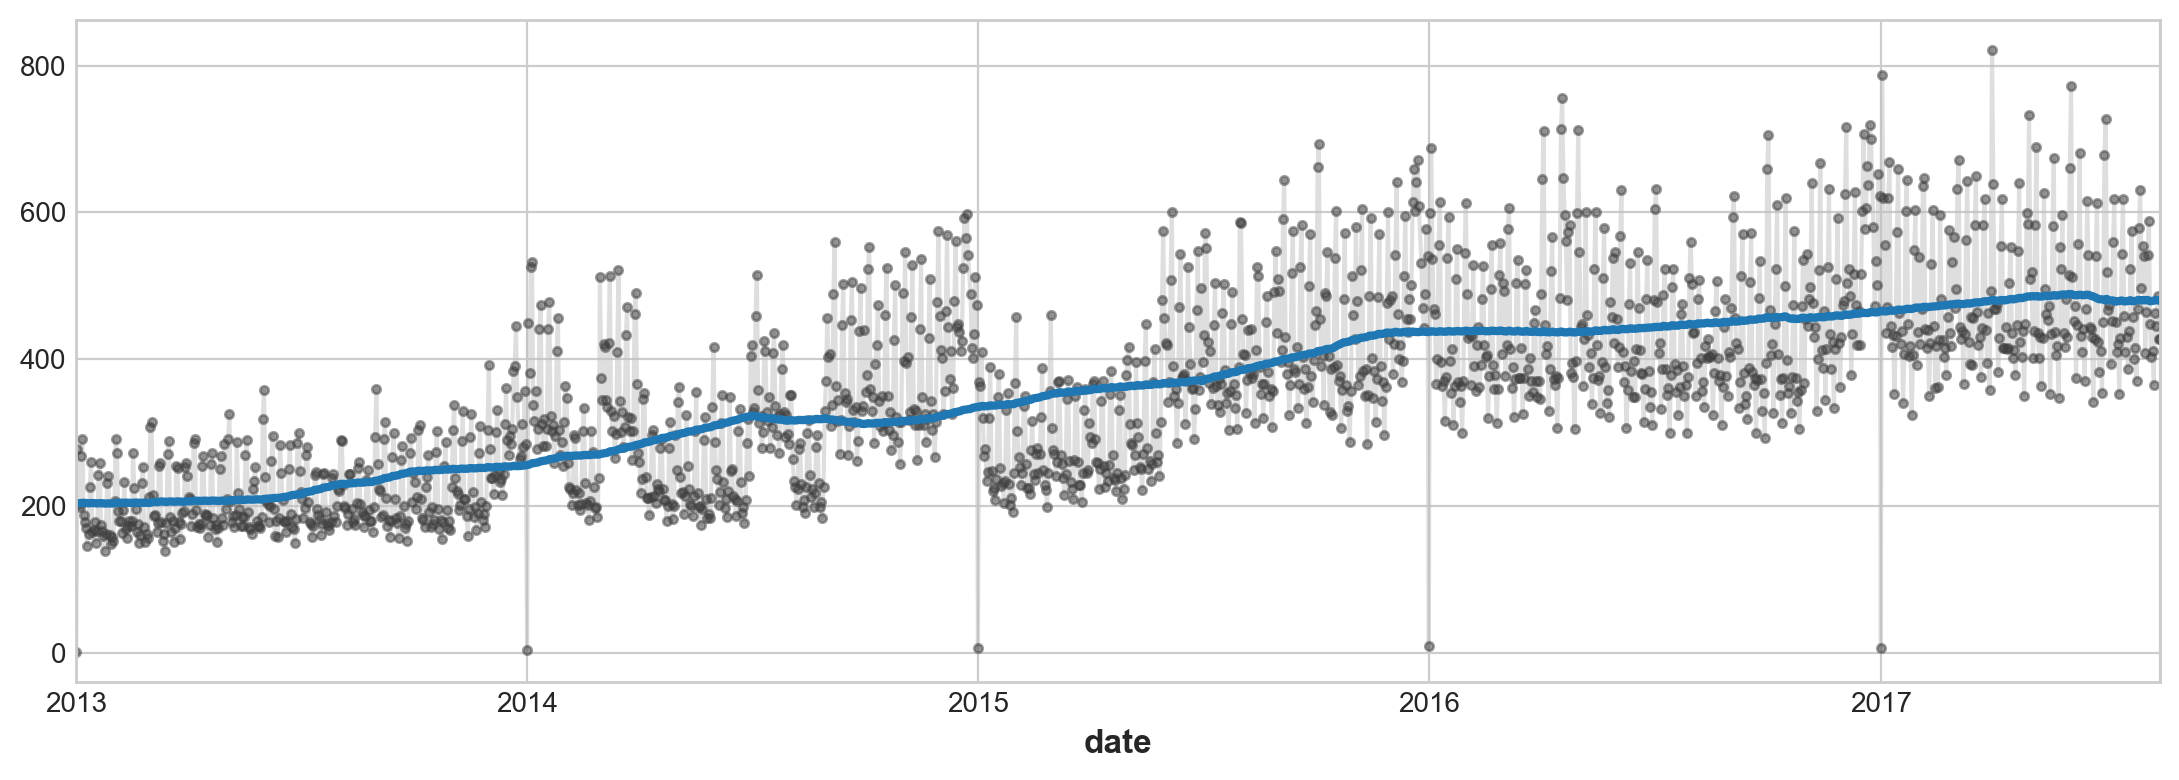

In [8]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 3) Create a Trend Feature

Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [9]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X =  dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)



# Check your answer
#q_3.check()

In [10]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

You can see the a plot of the result by running the next cell.

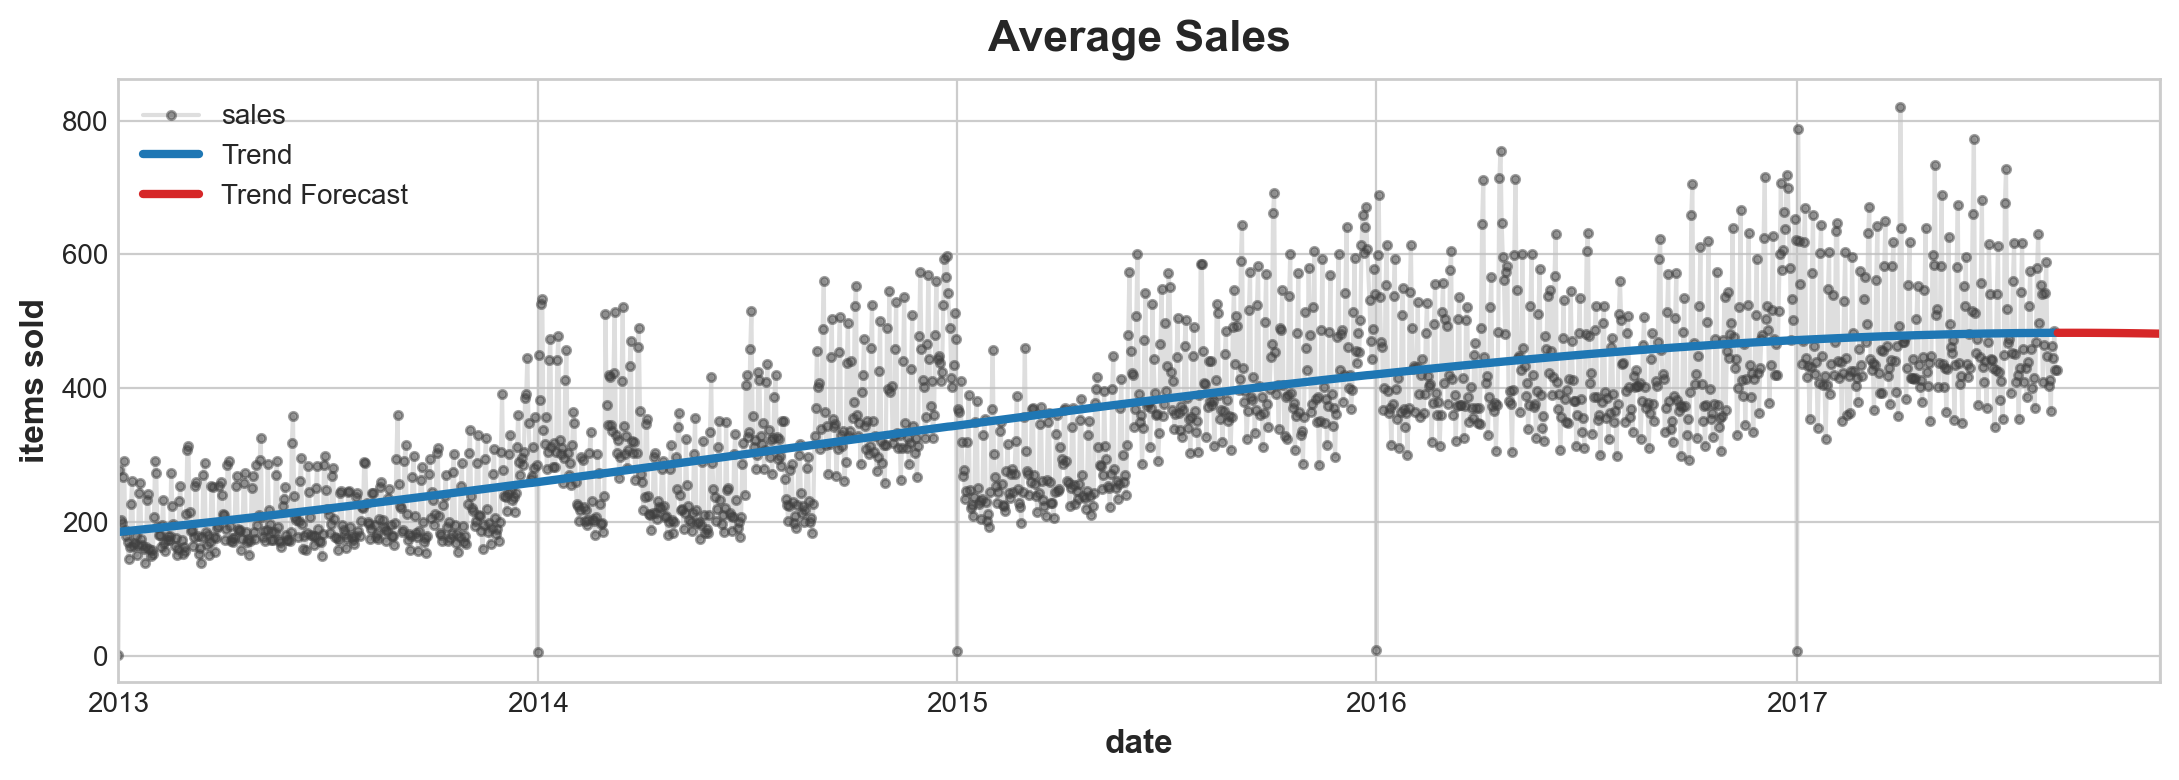

In [11]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

--------------------------------------------------------------------------------

One way to fit more complicated trends is to increase the order of the polynomial you use. To get a better fit to the somewhat complicated trend in *Store Sales*, we could try using an order 11 polynomial.

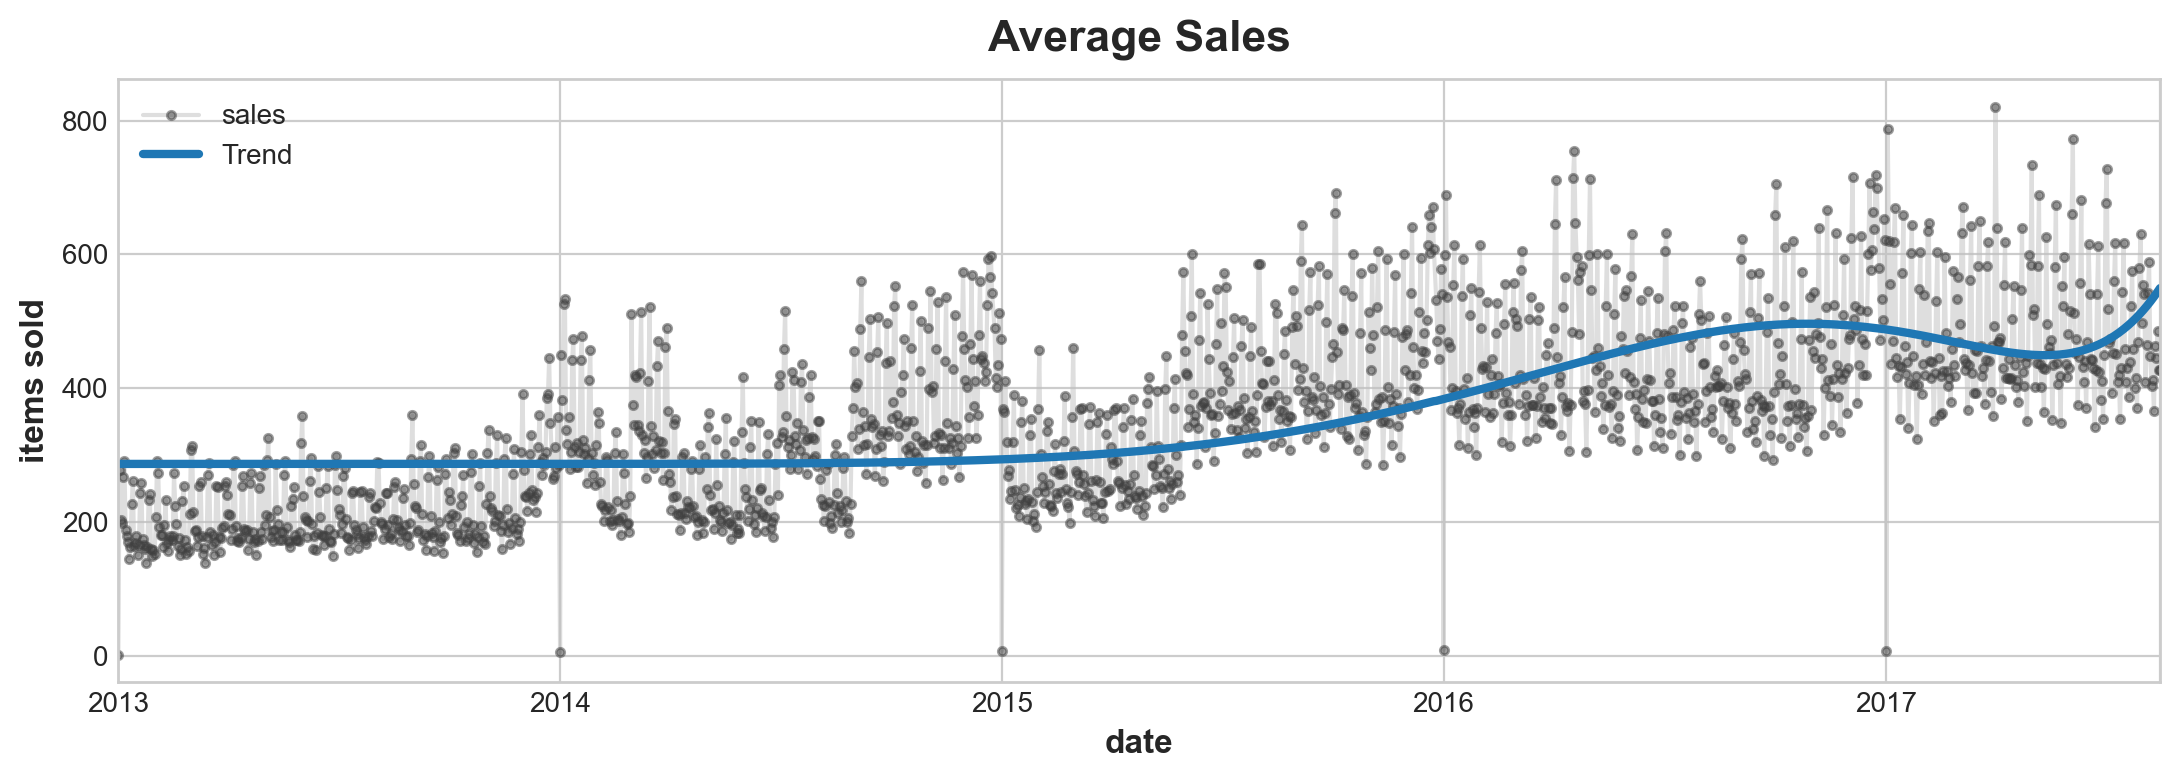

In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

# 4) Understand risks of forecasting with high-order polynomials

High-order polynomials are generally not well-suited to forecasting, however. Can you guess why?

In [13]:
# View the solution (Run this cell to receive credit!)
#q_4.check()

In [14]:
# Uncomment the next line for a hint
#q_4.hint()

Run this cell to see the same 90-day forecast using an order 11 polynomial. Does it confirm your intuition?

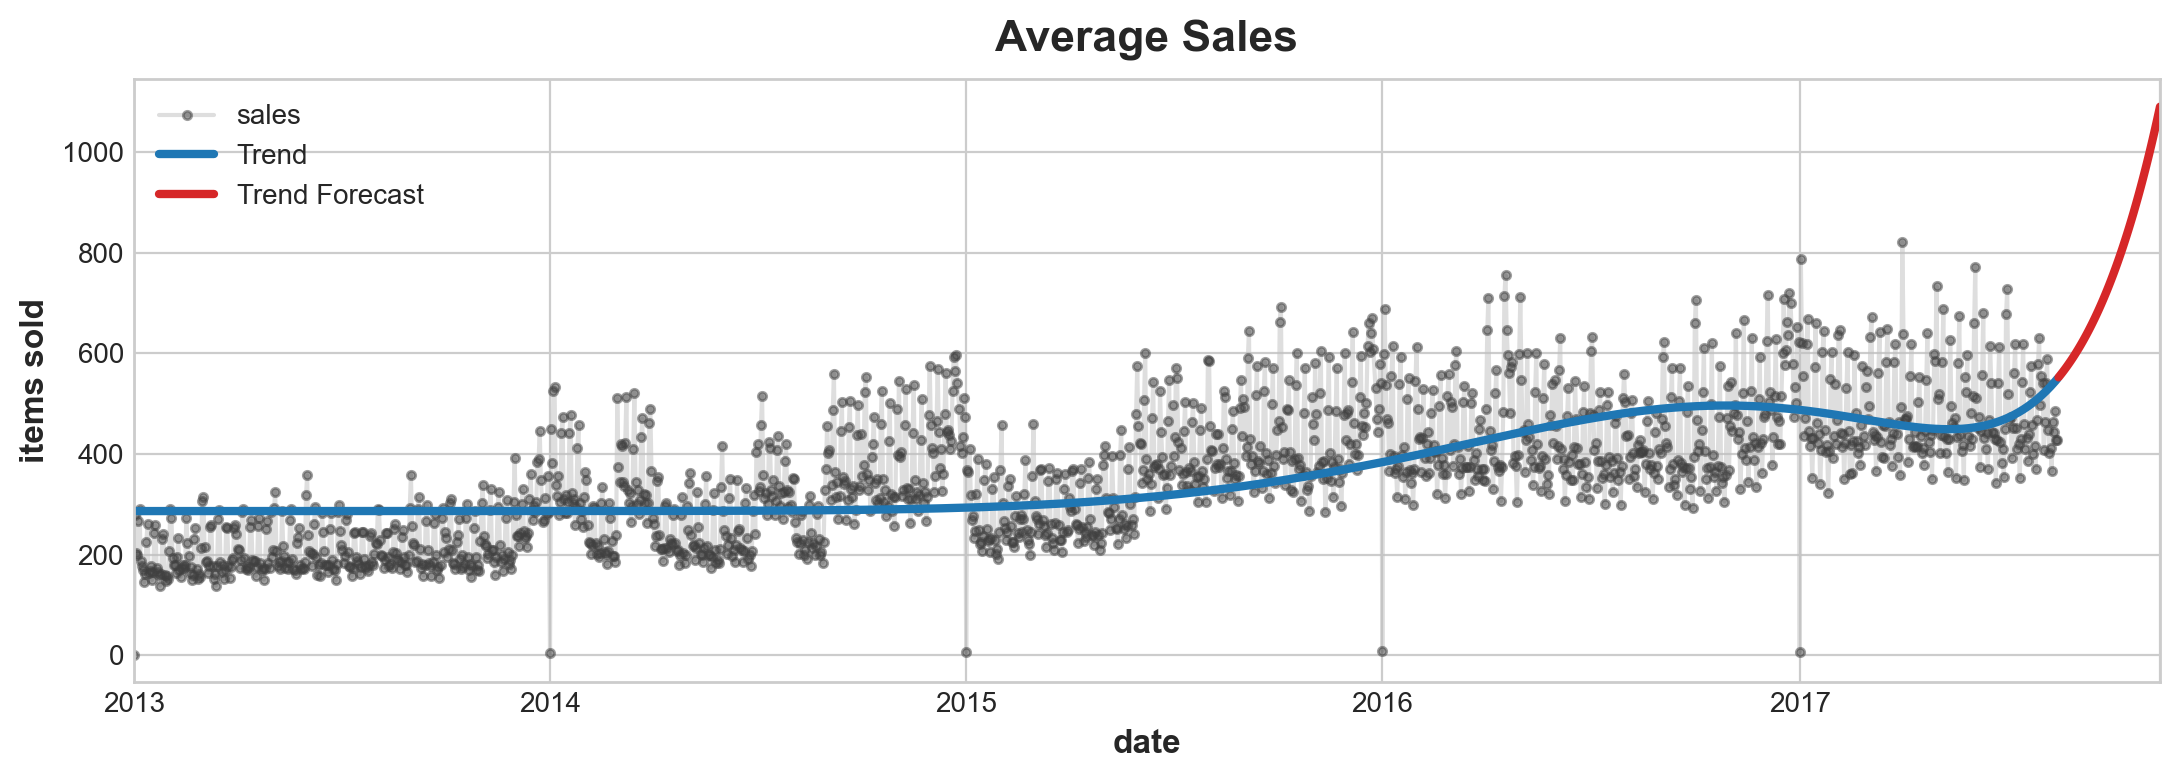

In [15]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

# Keep Going #

[**Model seasonality**](https://www.kaggle.com/ryanholbrook/seasonality), another common type of time dependence, with indicators and Fourier features.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*